In [115]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [116]:
maxVal = 7
colNum = (maxVal+1)*(maxVal+1)

In [117]:
ids_to_labels = {0: 'O',
                 1: 'B-nodirectiva',
                 2: 'B-sajat_hangu',
                 3: 'B-kozvetitett',
                 4: 'B-meta',
                 5: 'B-ambiguous',
                 6: 'B-szovegszervezo',
                 7: 'B-interakcios'}

labels_to_ids = {v: k for k, v in ids_to_labels.items()}
ids = list(ids_to_labels.keys())

In [118]:
seqlen = 512 # 64, 128, 256 vagy 512
df = pd.read_csv('cont_df_' + str(seqlen) + '.tsv', sep='\t').transpose()
colnames = []
for i in range(colNum):
    id = df[i]['true'] + df[i]['pred']
    colnames.append(id)
df = df.drop(columns=[colNum, colNum+1])
df = df.drop(['true', 'pred'])
df.columns = colnames
df

,00,01,02,03,04,05,06,07,10,11,...,66,67,70,71,72,73,74,75,76,77
1,3666,1,0,0,0,0,0,0,2,2,...,0,0,0,0,2,1,0,0,0,0
2,3676,1,0,0,0,0,0,0,2,11,...,1,0,0,0,0,0,0,0,0,0
3,3686,0,0,0,0,0,0,0,0,4,...,0,0,0,0,0,0,0,0,0,0
4,3673,0,0,0,0,0,0,0,0,6,...,1,0,0,0,0,0,0,0,0,0
5,3681,0,0,0,0,0,0,0,0,7,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
509,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
510,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
511,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [119]:
def getTP(df, vals):
    cols = [str(val)+str(val) for val in vals]
    return df.loc[:,cols].sum(axis=1)

def getFP(df, vals):
    cols = [str(i)+str(val) for i in range(maxVal) for val in vals if i != val]
    return df.loc[:,cols].sum(axis=1)

def getFN(df, vals):
    cols = [str(val) + str(i) for i in range(maxVal) for val in vals if i != val]
    return df.loc[:,cols].sum(axis=1)

def getPRF(tpList,fpList,fnList):
    P = []
    R = []
    F = []
    for tp, fp, fn in zip(tpList, fpList, fnList):
        P0 = tp/(tp+fp) if tp+fp > 0 else -1
        R0 = tp/(tp+fn) if tp+fn > 0 else -1
        if P0+R0 > 0:
            F0 = 2*P0*R0/(P0+R0)  
        else: 
            if P0+R0 == 0:
                F0 = 0
            else:
                F0 = -1
        P.append(P0)
        R.append(R0)
        F.append(F0)
    return P, R, F

In [120]:
def drawPRF(df, vals, order):
    if len(vals) > 1:
        title_f = 'all'
    else:
        title_f = ids_to_labels[vals[0]]
    tp = getTP(df, vals)
    fp = getFP(df, vals)
    fn = getFN(df, vals)
    P, R, F = getPRF(tp,fp,fn)
    ymin = min([abs(i) for i in P+R+F])
    x = []
    y = []
    for i in range(len(P)):
        if P[i] >= 0:
            x.append(i)
            y.append(P[i])

    mymodel = numpy.poly1d(numpy.polyfit(x, y, order))

    myline = numpy.linspace(1, max(x), max(x))
    
    yregr = mymodel(x)
    mse = mean_squared_error(y, yregr)

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(30,8))
    ax1.set_ylim([ymin, 1.0])
    ax2.set_ylim([ymin, 1.0])
    ax3.set_ylim([ymin, 1.0])
    plt.subplot(1, 3, 1)
    plt.scatter(x, y, s = 5)
    plt.plot(myline, mymodel(myline), linewidth=3.0, color="red")
    plt.title('seq_len: ' + str(seqlen) + '    ' + title_f + '   Precision   pol_order:' + str(fok) + f'   MSE: {mse:.4f}')
    # plt.show()

    # print('Recall')
    x = []
    y = []
    for i in range(len(R)):
        if R[i] >= 0:
            x.append(i)
            y.append(R[i])

    mymodel = numpy.poly1d(numpy.polyfit(x, y, order))

    myline = numpy.linspace(1, max(x), max(x))

    yregr = mymodel(x)
    mse = mean_squared_error(y, yregr)

    plt.subplot(1, 3, 2)
    plt.scatter(x, y, s = 5)
    plt.plot(myline, mymodel(myline), linewidth=3.0, color="red")
    plt.title('seq_len: ' + str(seqlen) + '    ' + title_f + '   Recall   pol_order:' + str(fok) + f'   MSE: {mse:.4f}')
    # plt.show()

    # print('F1')
    x = []
    y = []
    for i in range(len(F)):
        if F[i] >= 0:
            x.append(i)
            y.append(F[i])

    mymodel = numpy.poly1d(numpy.polyfit(x, y, order))

    myline = numpy.linspace(1, max(x), max(x))

    yregr = mymodel(x)
    mse = mean_squared_error(y, yregr)

    plt.subplot(1, 3, 3)
    plt.scatter(x, y, s = 5)
    plt.plot(myline, mymodel(myline), linewidth=3.0, color="red")
    plt.title('seq_len: ' + str(seqlen) + '    ' + title_f + '   F1   pol_order:' + str(fok) + f'   MSE: {mse:.4f}')
    plt.savefig('figs/fig_' + str(seqlen) + '_' + title_f + '_' + str(fok) +'.png', bbox_inches='tight')
    plt.show()


Összesített


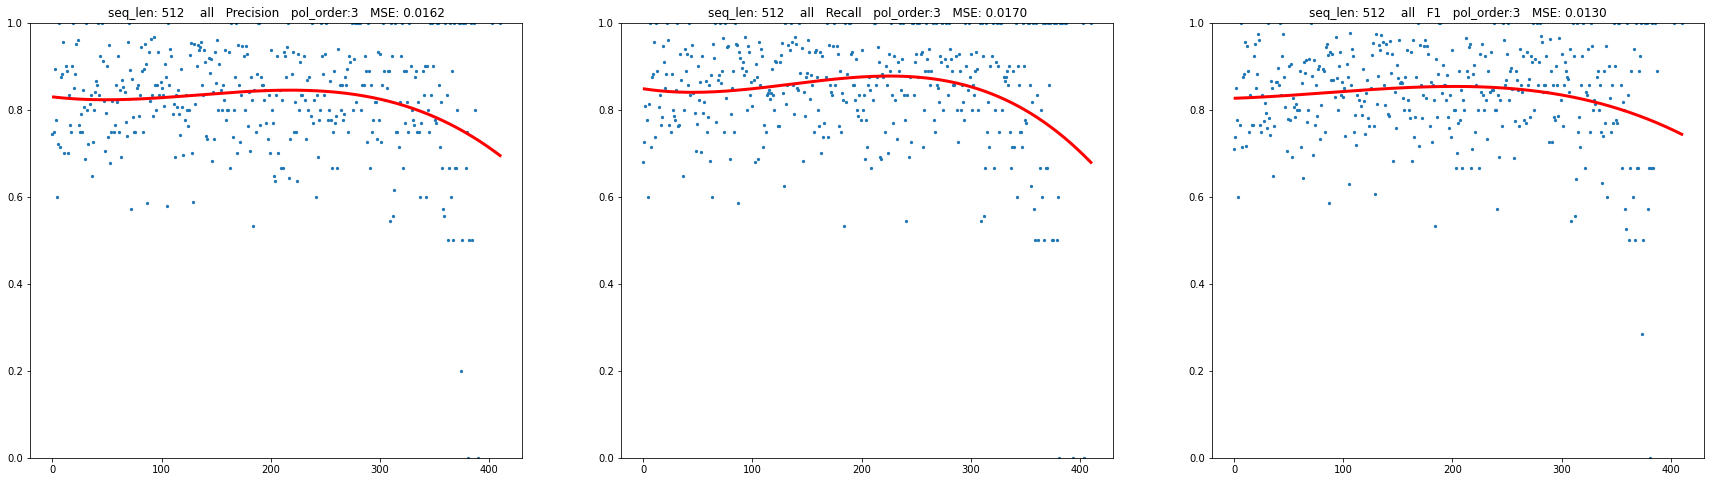

B-nodirectiva


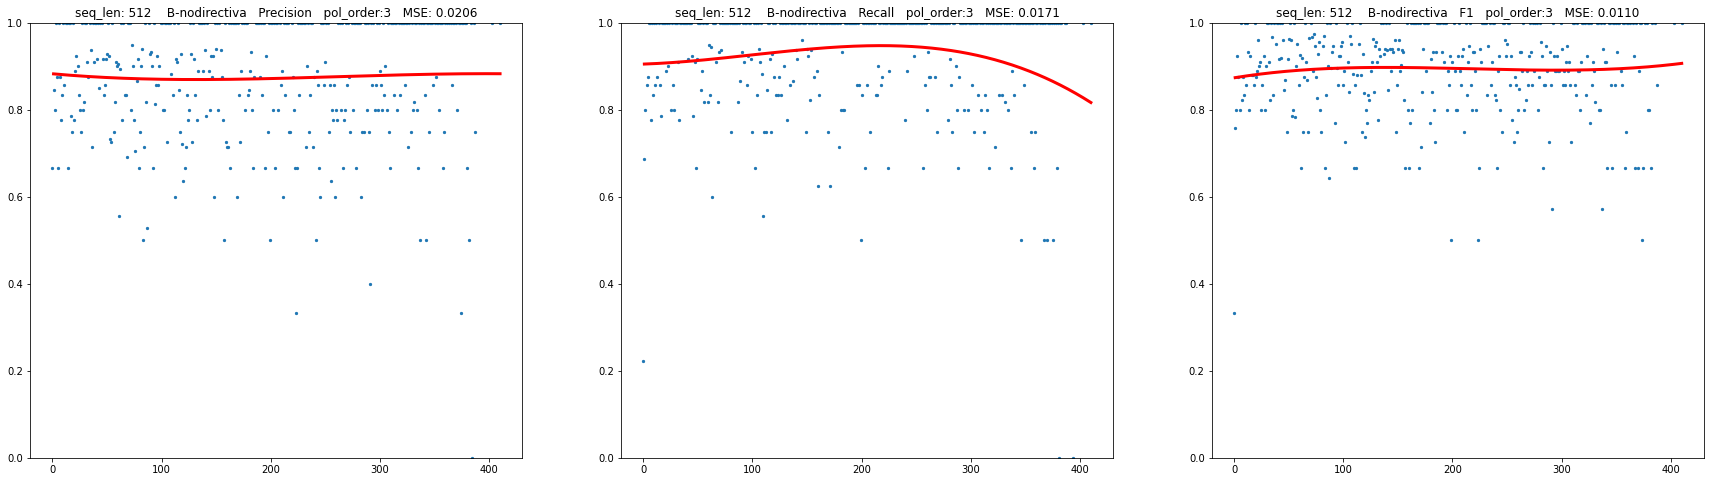

B-sajat_hangu


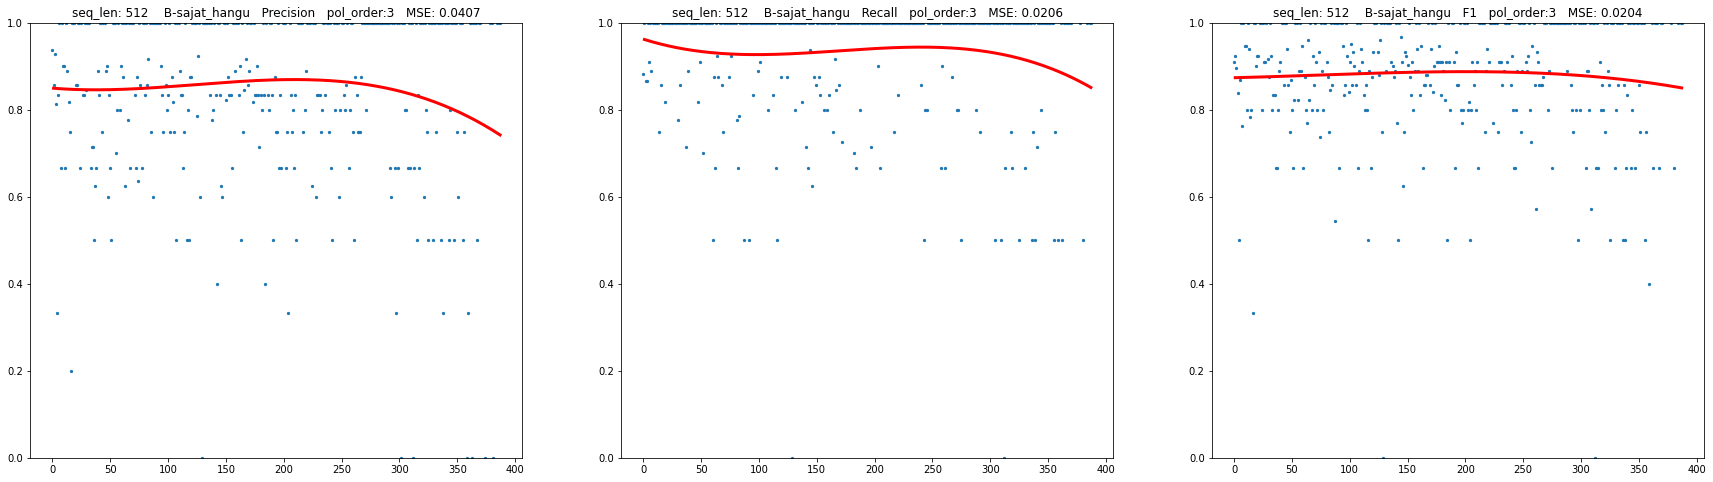

B-kozvetitett


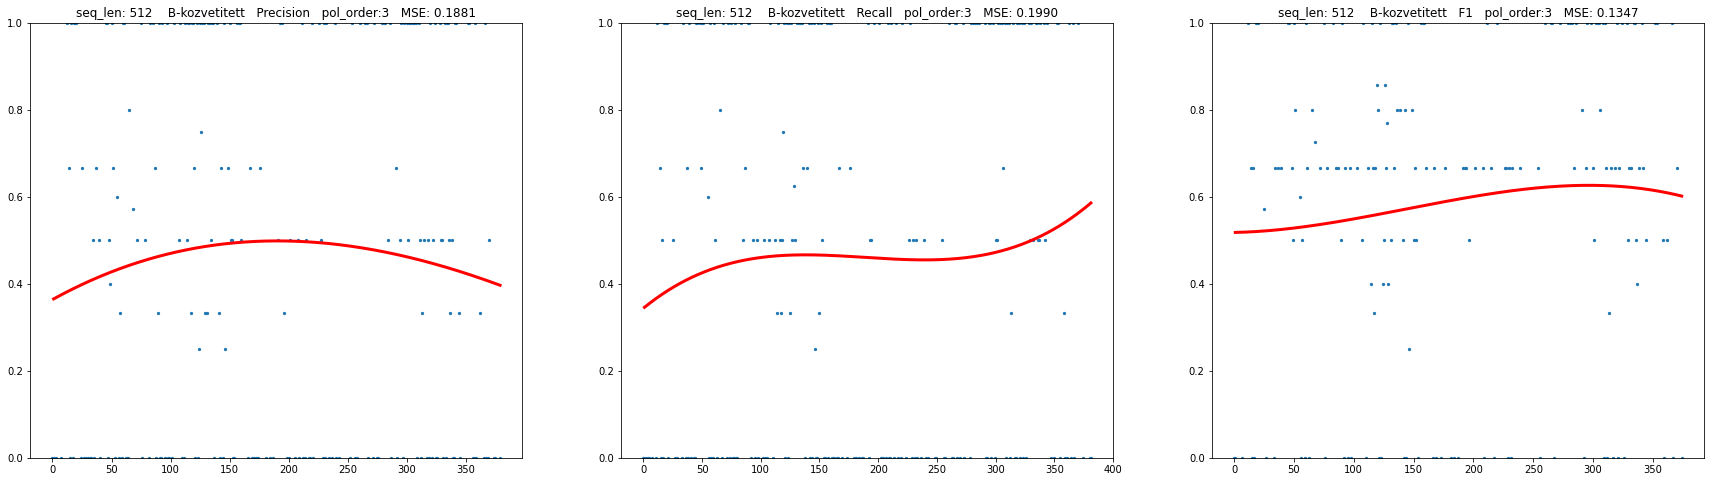

B-meta


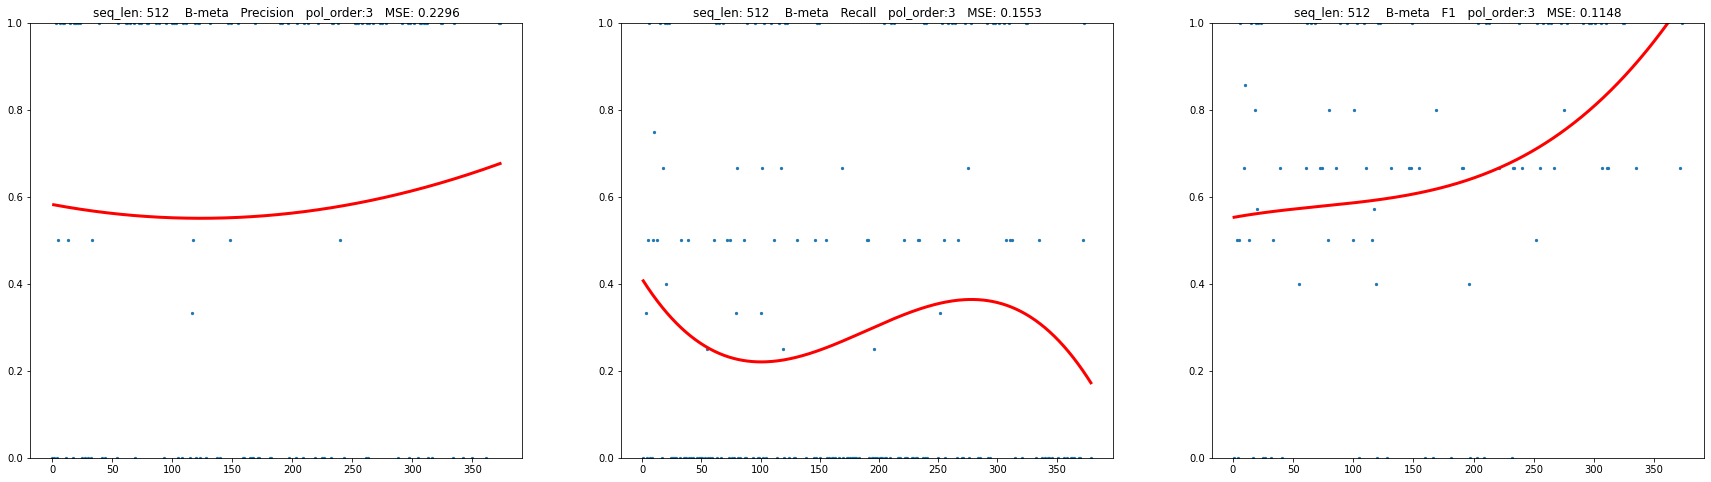

B-szovegszervezo


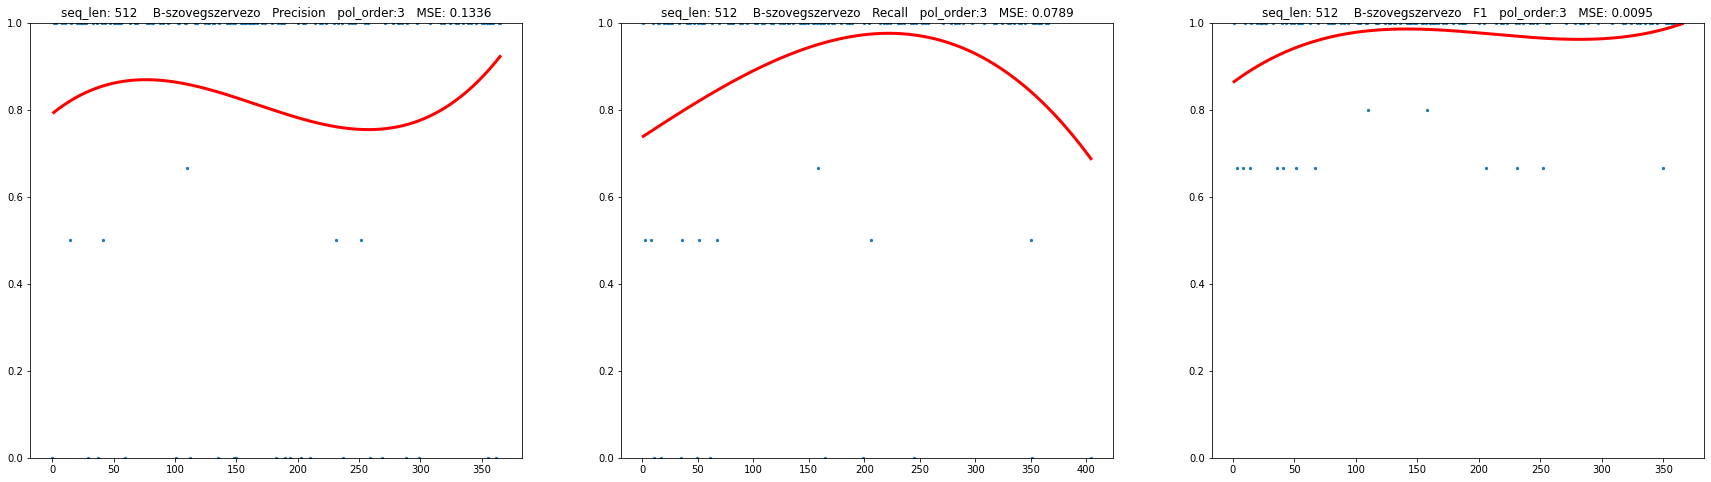

B-interakcios


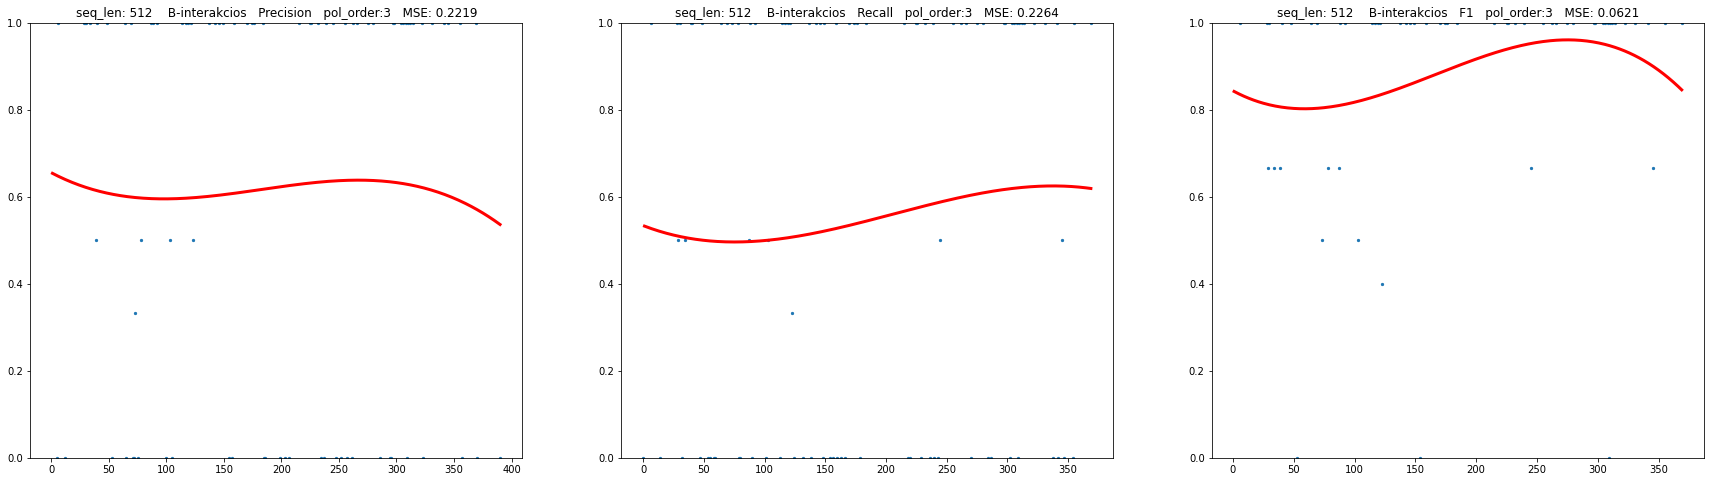

In [122]:
fok = 3
print('Összesített')
drawPRF(df, [1,2,3,4,5,6,7], fok)
for i in range(1, maxVal+1):
    if i != 5:
        print(ids_to_labels[i])
        drawPRF(df, [i], fok)

Összesített


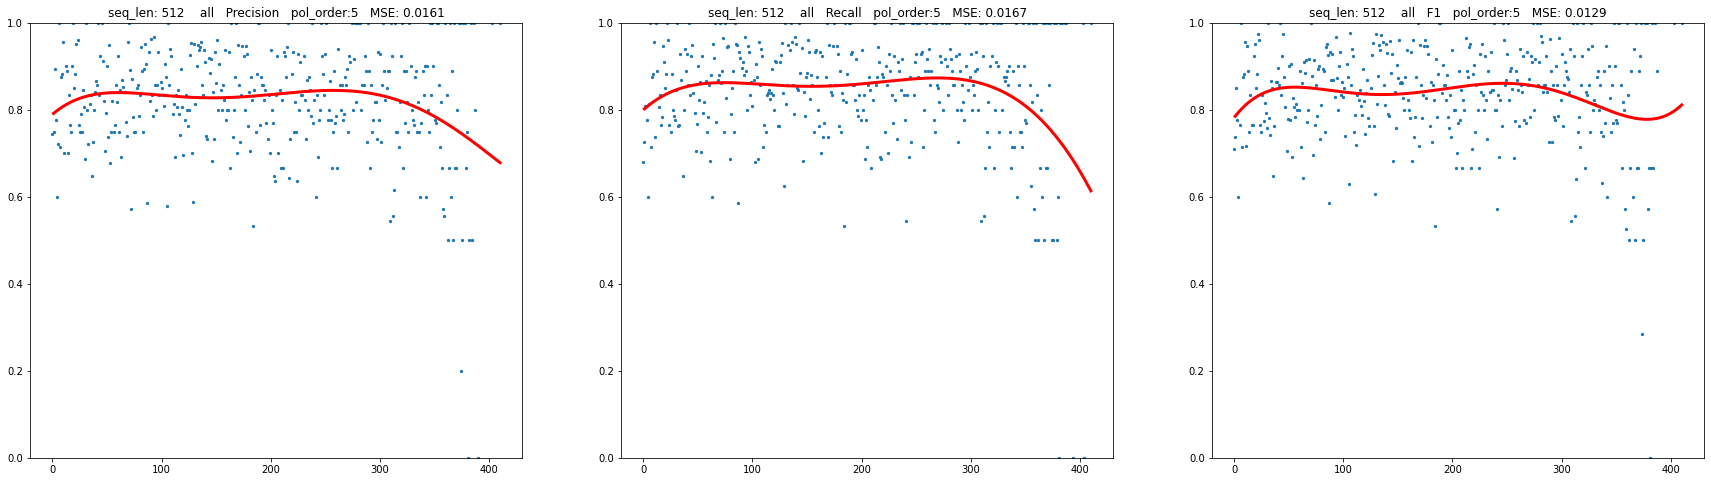

B-nodirectiva


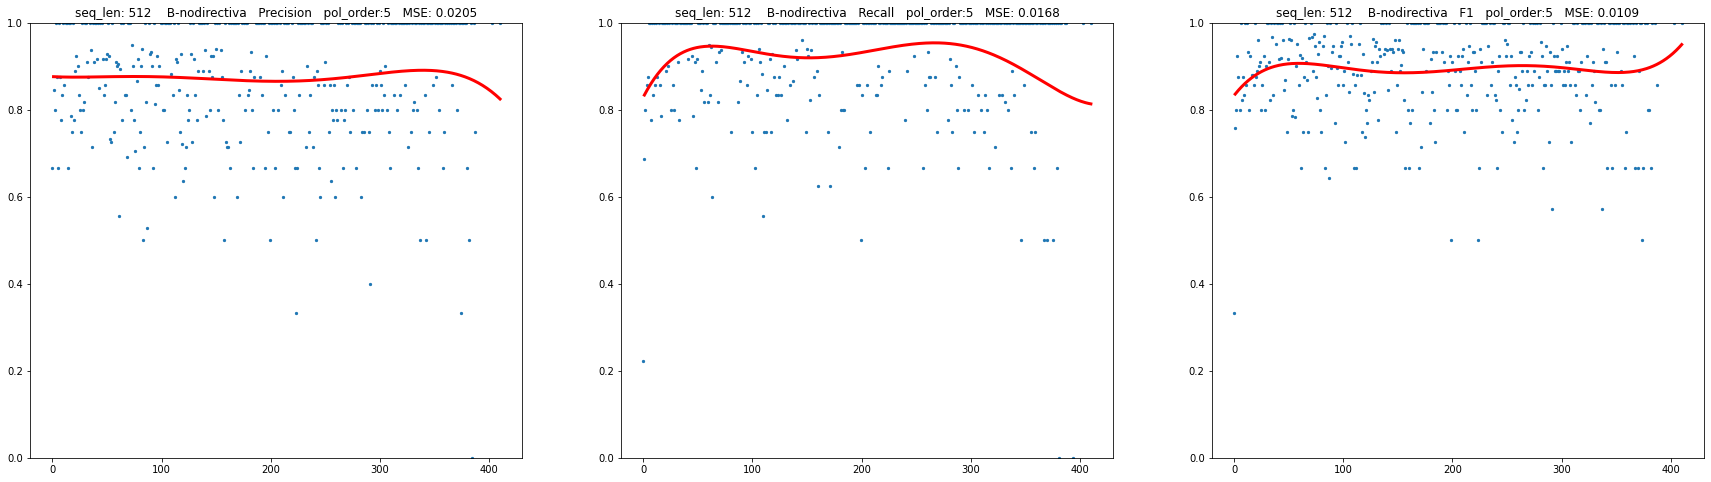

B-sajat_hangu


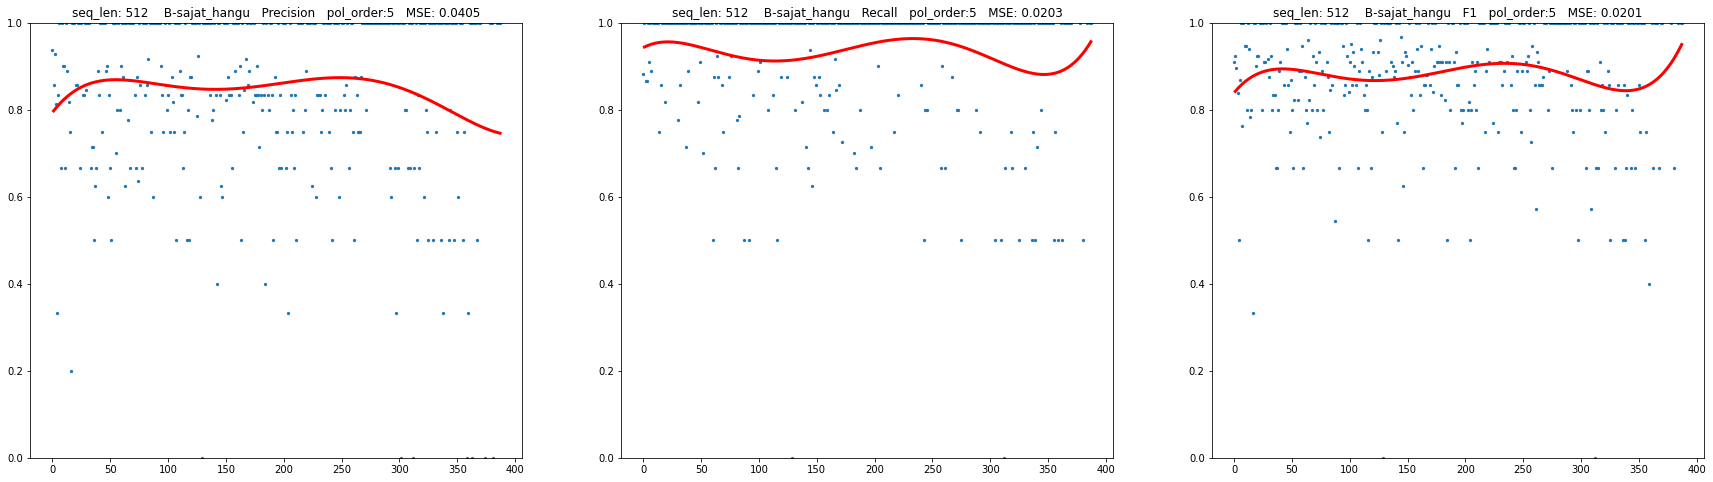

B-kozvetitett


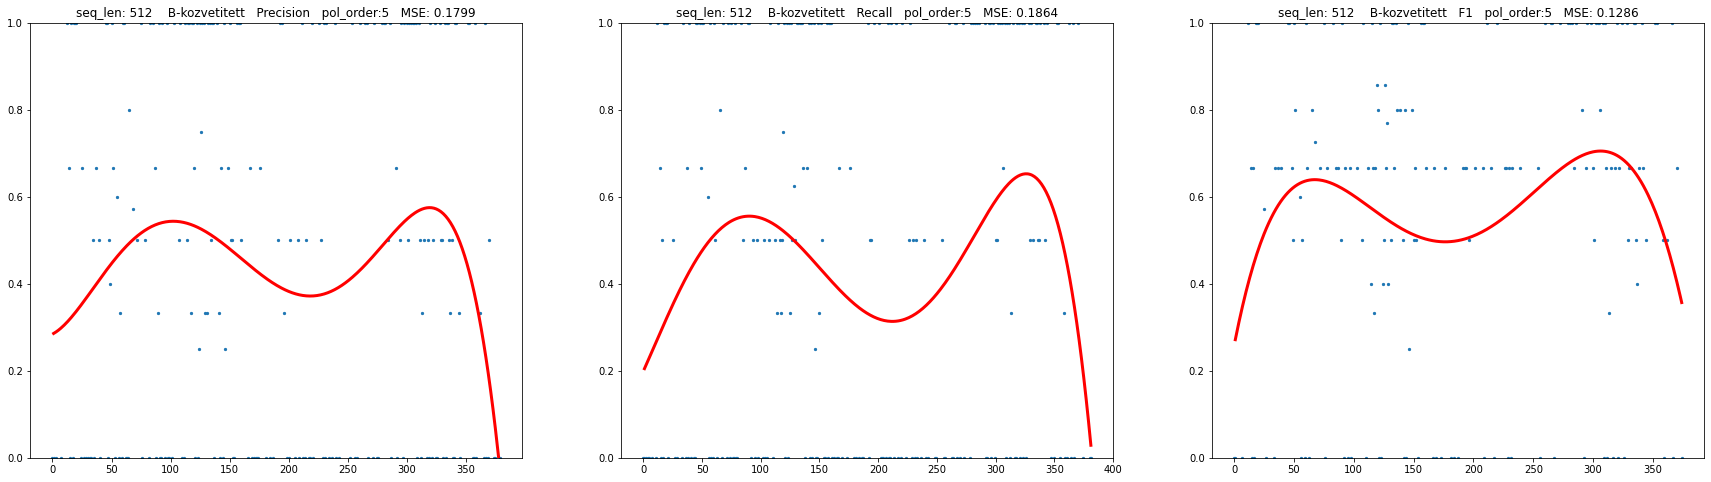

B-meta


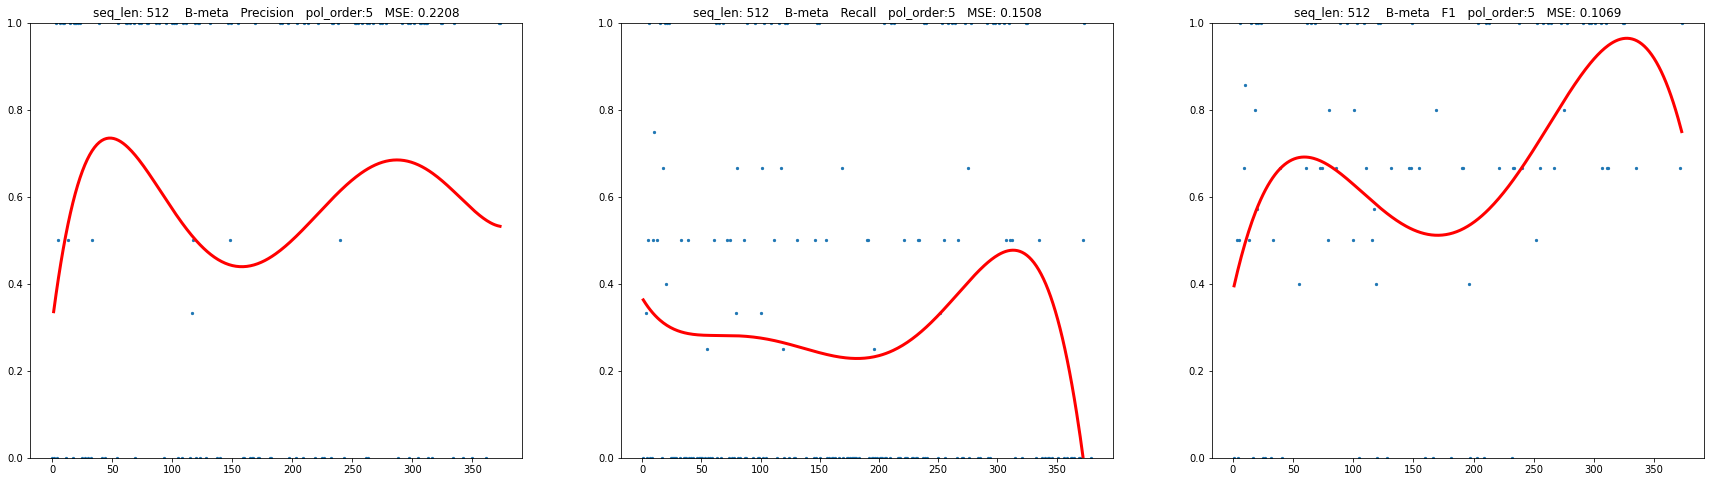

B-szovegszervezo


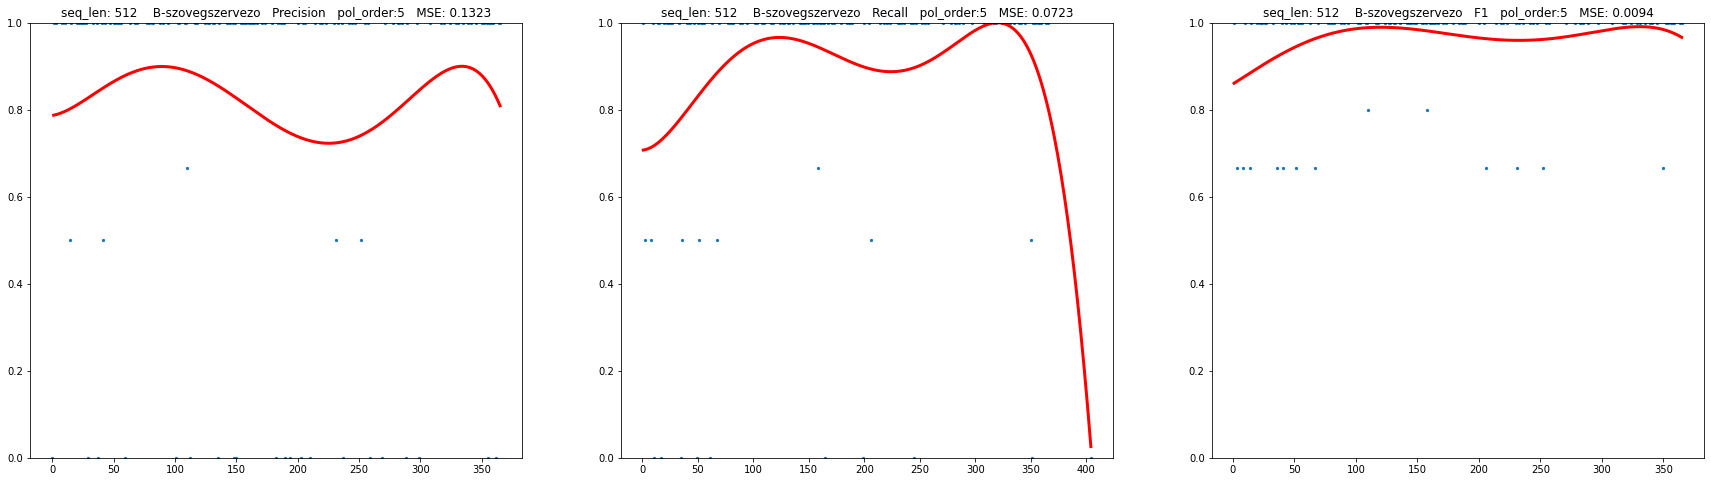

B-interakcios


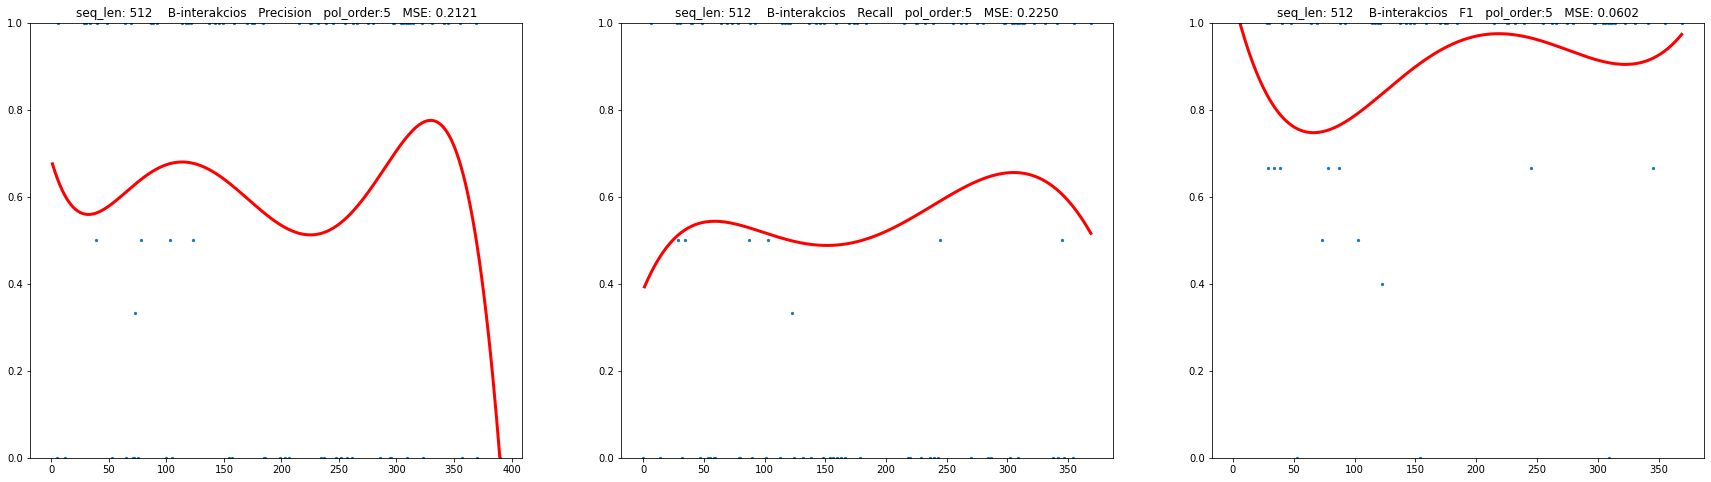

In [123]:
fok = 5
print('Összesített')
drawPRF(df, [1,2,3,4,5,6,7], fok)
for i in range(1, maxVal+1):
    if i != 5:
        print(ids_to_labels[i])
        drawPRF(df, [i], fok)